In [12]:
import pickle
import json
import numpy as np

In [48]:
sub_dir ='text_img'
im2recipe = np.load(f'../out/clip/{sub_dir}/im2recipe.npy')
recipe2im = np.load(f'../out/clip/{sub_dir}/recipe2im.npy')
with open(f'../out/clip/{sub_dir}/img_path','rb') as f:
    img_path = pickle.load(f)
with open(f'../out/clip/{sub_dir}/saved_ids','rb') as f:
    saved_ids = pickle.load(f)

In [49]:
with open('/home/parinayok/nutr1m/data_crawl/food.com_annotated_nutr_per_recipe.json') as f:
    nutr_per_recipes = json.load(f)
with open('/home/parinayok/nutr1m/data_crawl/food_ids_per_recipes.json') as f:
    food_ids_per_recipes = json.load(f)
with open('/home/parinayok/nutr1m/data_crawl/weighted_food_ids_per_recipes.json') as f:
    weighted_food_ids_per_recipes = json.load(f)

In [50]:
im2recipe_dict = {}
for i, sorted_recipe in enumerate(im2recipe):
    avail_sorted_recipe = [saved_ids[idx] for idx in sorted_recipe if idx != i][:20]
    im2recipe_dict[saved_ids[i]] = avail_sorted_recipe
save_path = f"results_clip/{sub_dir}.json"
with open(save_path,'w') as f:
    json.dump(im2recipe_dict,f,indent=2)

In [51]:
def cal_iou(input_1, input_2):
    input_1 = set(input_1)
    input_2 = set(input_2)
    u = input_1.union(input_2)
    i = input_1.intersection(input_2)
    return len(i) / len(u)
def cal_weighted_iou(input_1, input_2, w_1, w_2):
    all_weight = sum(w_1) + sum(w_2)
    intersect_weight = 0.
    for i, ingr in enumerate(input_1):
        if ingr in input_2:
            j = input_2.index(ingr)
            intersect_weight += w_1[i] + w_2[j]
    return intersect_weight / all_weight

In [52]:
# top k

def pred_nutr(top_k: int):

    gts = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    preds = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    absolute_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    percentage_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }

    for recipe_id, results in im2recipe_dict.items():
        top_k_results = results[:top_k]
        gt_nutr = nutr_per_recipes[recipe_id]
        pred_nutr = {}
        for nutr_name in gts.keys():
            pred_nutr[nutr_name] = sum([nutr_per_recipes[result][nutr_name] for result in top_k_results]) / top_k
        for nutr_name in gts.keys():
            gts[nutr_name].append(gt_nutr[nutr_name])
            preds[nutr_name].append(pred_nutr[nutr_name])
            absolute_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name]))
            if gt_nutr[nutr_name] < 0.1:
                percentage_errors[nutr_name].append(0)
            else:
                percentage_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name])/gt_nutr[nutr_name])
    return gts, preds, absolute_errors, percentage_errors

In [53]:
ious = []
weighted_ious = []
for recipe_id, results in im2recipe_dict.items():
    result = results[0]
    ious.append(cal_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[result]))
    weighted_ious.append(cal_weighted_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[result],weighted_food_ids_per_recipes[recipe_id]['weight'],weighted_food_ids_per_recipes[result]['weight']))
iou = sum(ious)/len(ious)
print(f'{iou*100:.02f}%')
weighted_iou = sum(weighted_ious)/len(weighted_ious)
print(f'{weighted_iou*100:.02f}%')

21.57%
39.87%


In [54]:
#top1
gts, preds, absolute_errors, percentage_errors = pred_nutr(1)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')
#toop5
gts, preds, absolute_errors, percentage_errors = pred_nutr(5)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')
#top10
gts, preds, absolute_errors, percentage_errors = pred_nutr(10)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')

energy: MAE = 1405.74, MAPE = 1.18, SE = 1395.87
fat: MAE = 85.75, MAPE = 4.87, SE = 81.85
carb: MAE = 158.95, MAPE = 2.76, SE = 191.63
protein: MAE = 58.33, MAPE = 2.32, SE = 58.82
2.78
energy: MAE = 1107.11, MAPE = 1.07, SE = 1395.87
fat: MAE = 68.51, MAPE = 5.40, SE = 81.85
carb: MAE = 130.74, MAPE = 2.99, SE = 191.63
protein: MAE = 45.37, MAPE = 2.42, SE = 58.82
2.97
energy: MAE = 1068.30, MAPE = 1.11, SE = 1395.87
fat: MAE = 65.51, MAPE = 5.52, SE = 81.85
carb: MAE = 128.12, MAPE = 2.95, SE = 191.63
protein: MAE = 43.86, MAPE = 2.41, SE = 58.82
3.00


0.3395
0.2694
0.4376
0.3136


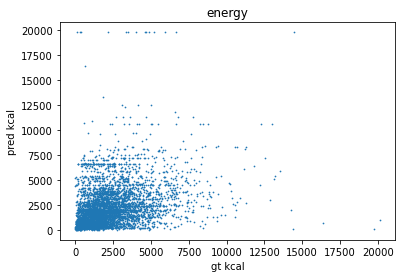

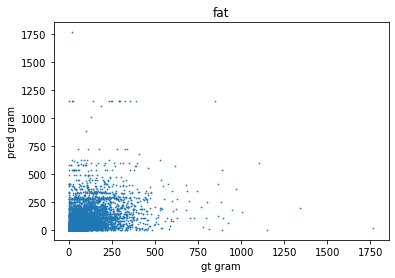

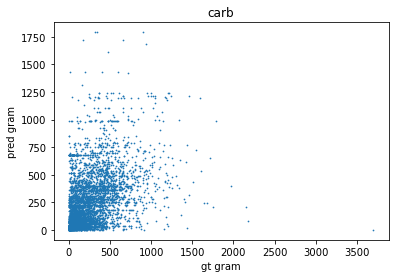

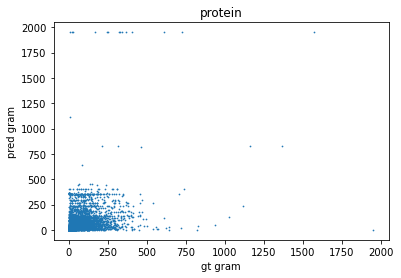

In [8]:
import matplotlib.pyplot as plt

for nutr_name in gts.keys():
    cc = np.corrcoef(gts[nutr_name],preds[nutr_name])[0,1]
    print(f'{cc:.04f}')
    plt.figure()
    plt.scatter(gts[nutr_name],preds[nutr_name],s=0.5)
    if nutr_name == 'energy':
        plt.xlabel('gt kcal')
        plt.ylabel('pred kcal')
        # plt.xlim((0,2500))
        # plt.ylim((0,2500))
    else:
        plt.xlabel('gt gram')
        plt.ylabel('pred gram')
        # plt.xlim((0,200))
        # plt.ylim((0,200))
    plt.title(nutr_name)

In [9]:
# top k

def pred_nutr(top_k: int):

    gts = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    preds = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    absolute_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    percentage_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }

    for recipe_id, results in im2recipe_dict.items():
        top_k_results = results[:top_k]
        gt_nutr = nutr_per_recipes[recipe_id]
        pred_nutr = {}
        for nutr_name in gts.keys():
            pred_nutr[nutr_name] = sum([nutr_per_recipes[result][nutr_name] for result in top_k_results]) / top_k
        for nutr_name in gts.keys():
            gts[nutr_name].append(gt_nutr[nutr_name])
            preds[nutr_name].append(pred_nutr[nutr_name])
            absolute_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name]))
            if gt_nutr[nutr_name] < 0.1:
                percentage_errors[nutr_name].append(0)
            else:
                percentage_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name])/gt_nutr[nutr_name])
    return gts, preds, absolute_errors, percentage_errors

In [10]:
# top 5

import numpy as np
gts, preds, absolute_errors, percentage_errors = pred_nutr(5)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')

energy: MAE = 1172.86, MAPE = 1.24, SE = 1395.87
fat: MAE = 72.25, MAPE = 6.03, SE = 81.85
carb: MAE = 140.73, MAPE = 3.79, SE = 191.63
protein: MAE = 47.99, MAPE = 3.09, SE = 58.82
3.54


0.4830
0.3918
0.5716
0.4418


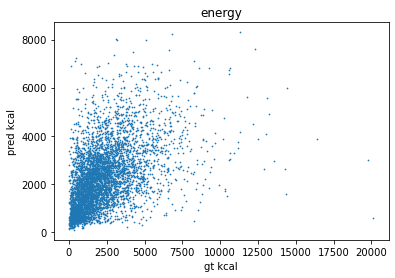

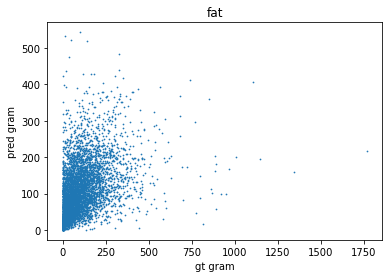

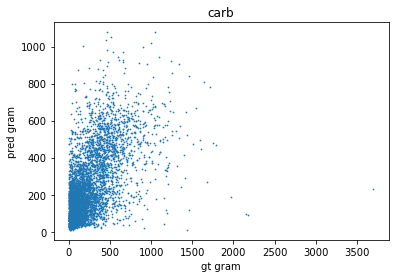

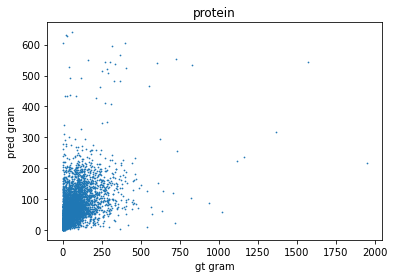

In [11]:
import matplotlib.pyplot as plt

for nutr_name in gts.keys():
    cc = np.corrcoef(gts[nutr_name],preds[nutr_name])[0,1]
    print(f'{cc:.04f}')
    plt.figure()
    plt.scatter(gts[nutr_name],preds[nutr_name],s=0.5)
    if nutr_name == 'energy':
        plt.xlabel('gt kcal')
        plt.ylabel('pred kcal')
    else:
        plt.xlabel('gt gram')
        plt.ylabel('pred gram')
    plt.title(nutr_name)

In [12]:
# top 10

gts, preds, absolute_errors, percentage_errors = pred_nutr(10)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')

energy: MAE = 1114.43, MAPE = 1.25, SE = 1395.87
fat: MAE = 68.75, MAPE = 6.03, SE = 81.85
carb: MAE = 135.70, MAPE = 3.54, SE = 191.63
protein: MAE = 45.58, MAPE = 2.92, SE = 58.82
3.44


0.5182
0.4327
0.5961
0.4886


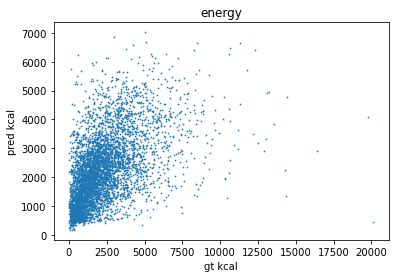

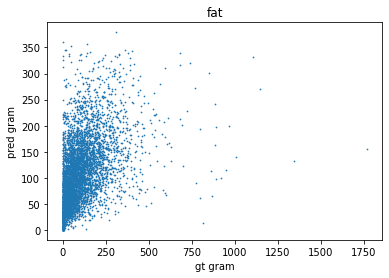

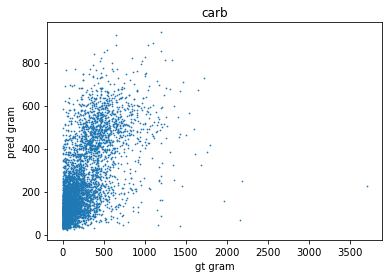

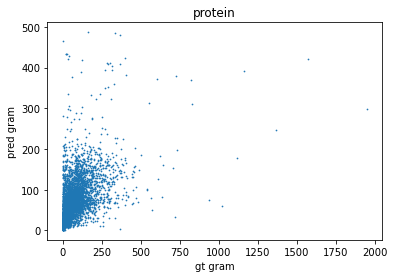

In [13]:
import matplotlib.pyplot as plt

for nutr_name in gts.keys():
    cc = np.corrcoef(gts[nutr_name],preds[nutr_name])[0,1]
    print(f'{cc:.04f}')
    plt.figure()
    plt.scatter(gts[nutr_name],preds[nutr_name],s=0.5)
    if nutr_name == 'energy':
        plt.xlabel('gt kcal')
        plt.ylabel('pred kcal')
    else:
        plt.xlabel('gt gram')
        plt.ylabel('pred gram')
    plt.title(nutr_name)